In [1]:
# !pip3 install -U torch_geometric
# !pip3 install -U torch-scatter
# !pip3 install -U torch-sparse
# !pip3 install -U pandas
# !pip3 install -U numpy
# !pip3 install -U matplotlib
# !pip3 install -U sklearn
# !pip3 install -U PyTDC 
# !pip3 install -U pre-commit
# !pip3 install -U plotly
# !pip3 install -U tdc 
# !pip3 install -U ogb

In [2]:
# !pip install ogb==1.2.6

In [3]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdkit

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from tdc.single_pred import Tox
from rdkit.Chem import AllChem
from rdkit import Chem

from time import time

<IPython.core.display.Javascript object>

In [5]:
from featurizers.fingerprints import (
    MorganFingerprint,
    MACCSKeysFingerprint,
    AtomPairFingerprint,
    TopologicalTorsionFingerprint,
    ERGFingerprint,
)

from rdkit.Chem import MolFromSmiles

<IPython.core.display.Javascript object>

In [6]:
hiv_df = pd.read_csv("data/mol.csv.gz")

<IPython.core.display.Javascript object>

In [7]:
hiv_df.head(8)

,HIV_active,smiles,mol_id
0,0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,NaN
1,0,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,NaN
2,0,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,NaN
3,0,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,NaN
4,0,O=S(=O)(O)CCS(=O)(=O)O,NaN
5,0,CCOP(=O)(Nc1cccc(Cl)c1)OCC,NaN
6,0,O=C(O)c1ccccc1O,NaN
7,0,CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O,NaN


<IPython.core.display.Javascript object>

In [8]:
X = hiv_df["smiles"]

<IPython.core.display.Javascript object>

In [9]:
n_molecules = X.shape[0]
n_molecules

41127

<IPython.core.display.Javascript object>

In [10]:
def get_times_emf(X, n_molecules, transformer_function, **kwargs):
    result = []
    emf_transformer = transformer_function(**kwargs)
    for part in range(2, 11, 2):
        n = (n_molecules * part) // 10
        subset = X[:n]
        times = [None for i in range(5)]
        for i in range(5):
            start = time()
            X_transformed = emf_transformer.transform(subset)
            end = time()

            times[i] = end - start
        result.append(sum(times) / 5)
    return np.array(result)

<IPython.core.display.Javascript object>

In [11]:
def get_times_rdkit(X, n_molecules, func, **kwargs):
    result = []
    for part in range(2, 11, 2):
        n = (n_molecules * part) // 10
        subset = X[:n]
        times = [None for i in range(5)]
        for i in range(5):
            start = time()
            X_transformed = [func(MolFromSmiles(x), **kwargs) for x in subset]
            end = time()

            times[i] = end - start
        result.append(sum(times) / 5)
    return np.array(result)

<IPython.core.display.Javascript object>

In [20]:
def plot_results(y_emf, y_rdkit, title=""):
    # X = np.arange(2, 11, 2)
    # y_emf = y_emf * 1000 / (n_molecules * X / 10)
    # y_rdkit = y_rdkit * 1000 / (n_molecules * X / 10)

    X = (n_molecules * np.arange(2, 11, 2)) // 10

    plt.rcParams["font.size"] = 20
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot()
    ax1.set_title(title)

    ax1.plot(X, y_emf[0], label="emf time - 1 core")
    ax1.plot(X, y_emf[1], label="emf time - 2 cores")
    ax1.plot(X, y_emf[2], label="emf time - 4 cores")
    ax1.plot(X, y_emf[3], label="emf time - all cores")
    ax1.plot(X, y_rdkit, label="rdkit time")

    ax1.set_ylabel("Time of computiation")
    ax1.set_xlabel("Number of finberprints")

    ax1.set_xlim(n_molecules * 0.1, n_molecules * 1.1)
    ax1.set_ylim(bottom=0)

    plt.legend(loc="upper left")
    plt.show()

<IPython.core.display.Javascript object>

In [13]:
cores = [1, 2, 4, -1]

<IPython.core.display.Javascript object>

## Morgan Fingerprint

In [14]:
fingerprint_types = ["default", "as_bit_vect", "hashed"]
morgan_emf_times = [
    [
        get_times_emf(
            X, n_molecules, MorganFingerprint, result_type=tp, radius=3, n_jobs=n_cores
        )
        for n_cores in cores
    ]
    for tp in fingerprint_types
]

[15:39:11] WARNING: not removing hydrogen atom without neighbors
[15:39:11] WARNING: not removing hydrogen atom without neighbors
[15:39:26] WARNING: not removing hydrogen atom without neighbors
[15:39:26] WARNING: not removing hydrogen atom without neighbors
[15:39:42] WARNING: not removing hydrogen atom without neighbors
[15:39:42] WARNING: not removing hydrogen atom without neighbors
[15:39:57] WARNING: not removing hydrogen atom without neighbors
[15:39:57] WARNING: not removing hydrogen atom without neighbors
[15:40:13] WARNING: not removing hydrogen atom without neighbors
[15:40:13] WARNING: not removing hydrogen atom without neighbors
[15:52:01] WARNING: not removing hydrogen atom without neighbors
[15:52:01] WARNING: not removing hydrogen atom without neighbors
[15:52:45] WARNING: not removing hydrogen atom without neighbors
[15:52:45] WARNING: not removing hydrogen atom without neighbors
[15:53:29] WARNING: not removing hydrogen atom without neighbors
[15:53:29] WARNING: not r

<IPython.core.display.Javascript object>

In [17]:
from rdkit.Chem.rdMolDescriptors import (
    GetMorganFingerprint,
    GetMorganFingerprintAsBitVect,
    GetHashedMorganFingerprint,
)

functions = [
    GetMorganFingerprint,
    GetMorganFingerprintAsBitVect,
    GetHashedMorganFingerprint,
]
morgan_rdkit_times = [
    get_times_rdkit(X, n_molecules, function, radius=3) for function in functions
]

[16:26:34] WARNING: not removing hydrogen atom without neighbors
[16:26:34] WARNING: not removing hydrogen atom without neighbors
[16:26:49] WARNING: not removing hydrogen atom without neighbors
[16:26:49] WARNING: not removing hydrogen atom without neighbors
[16:27:04] WARNING: not removing hydrogen atom without neighbors
[16:27:04] WARNING: not removing hydrogen atom without neighbors
[16:27:19] WARNING: not removing hydrogen atom without neighbors
[16:27:19] WARNING: not removing hydrogen atom without neighbors
[16:27:34] WARNING: not removing hydrogen atom without neighbors
[16:27:34] WARNING: not removing hydrogen atom without neighbors
[16:30:11] WARNING: not removing hydrogen atom without neighbors
[16:30:11] WARNING: not removing hydrogen atom without neighbors
[16:30:25] WARNING: not removing hydrogen atom without neighbors
[16:30:25] WARNING: not removing hydrogen atom without neighbors
[16:30:39] WARNING: not removing hydrogen atom without neighbors
[16:30:39] WARNING: not r

<IPython.core.display.Javascript object>

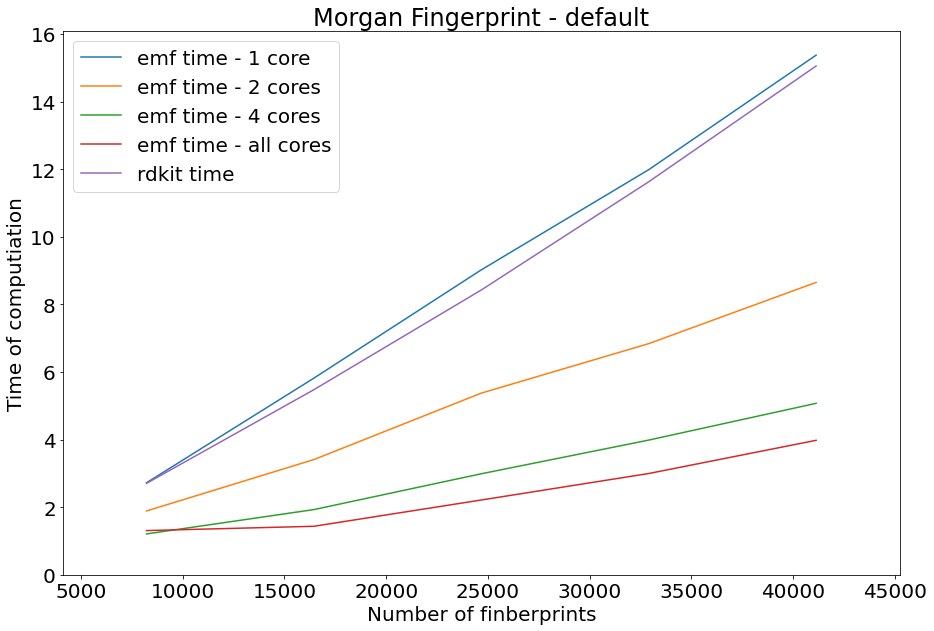

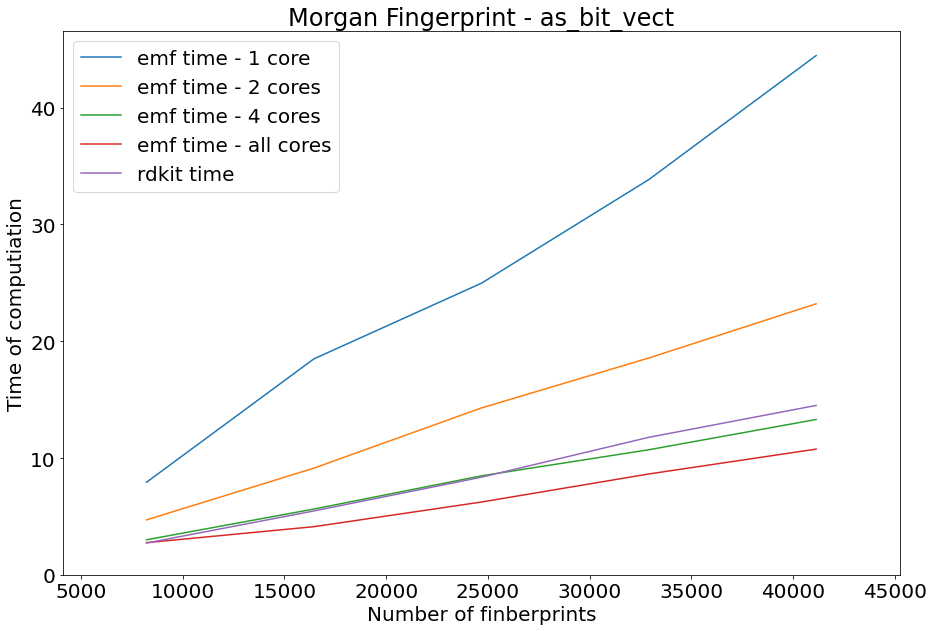

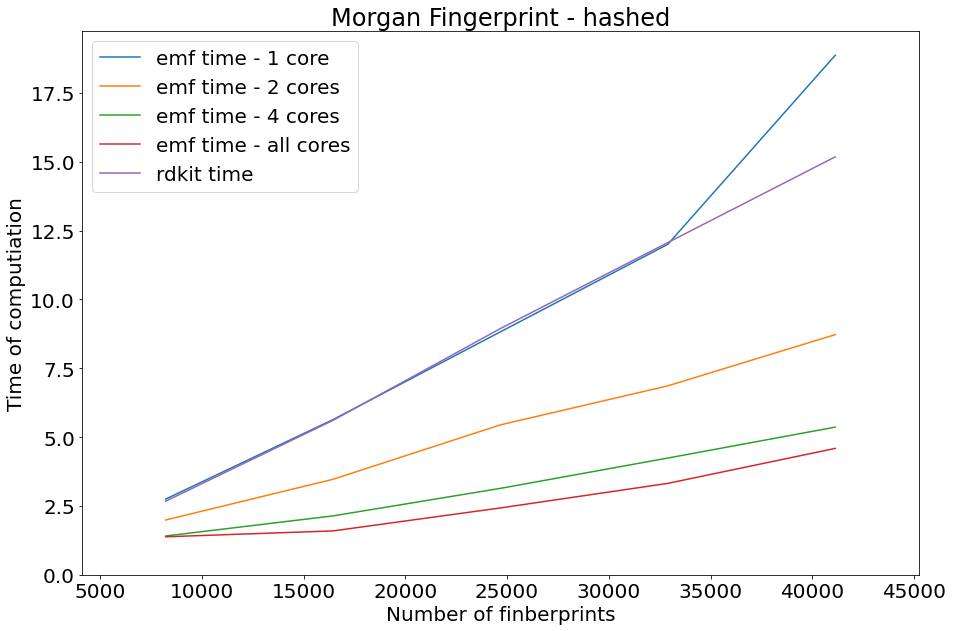

<IPython.core.display.Javascript object>

In [21]:
for i in range(3):
    plot_results(
        morgan_emf_times[i],
        morgan_rdkit_times[i],
        "Morgan Fingerprint - " + fingerprint_types[i],
    )

## MACCS Keys

In [22]:
MACCSKeys_emf_times = [
    get_times_emf(X, n_molecules, MACCSKeysFingerprint, n_jobs=n_cores)
    for n_cores in cores
]

[17:02:06] WARNING: not removing hydrogen atom without neighbors
[17:02:06] WARNING: not removing hydrogen atom without neighbors
[17:03:40] WARNING: not removing hydrogen atom without neighbors
[17:03:40] WARNING: not removing hydrogen atom without neighbors
[17:04:59] WARNING: not removing hydrogen atom without neighbors
[17:04:59] WARNING: not removing hydrogen atom without neighbors
[17:06:17] WARNING: not removing hydrogen atom without neighbors
[17:06:17] WARNING: not removing hydrogen atom without neighbors
[17:07:35] WARNING: not removing hydrogen atom without neighbors
[17:07:35] WARNING: not removing hydrogen atom without neighbors


<IPython.core.display.Javascript object>

In [23]:
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint

MACCSKeys_rdkit_times = get_times_rdkit(X, n_molecules, GetMACCSKeysFingerprint)

[17:42:48] WARNING: not removing hydrogen atom without neighbors
[17:42:48] WARNING: not removing hydrogen atom without neighbors
[17:44:02] WARNING: not removing hydrogen atom without neighbors
[17:44:02] WARNING: not removing hydrogen atom without neighbors
[17:45:15] WARNING: not removing hydrogen atom without neighbors
[17:45:15] WARNING: not removing hydrogen atom without neighbors
[17:46:29] WARNING: not removing hydrogen atom without neighbors
[17:46:29] WARNING: not removing hydrogen atom without neighbors
[17:47:42] WARNING: not removing hydrogen atom without neighbors
[17:47:42] WARNING: not removing hydrogen atom without neighbors


<IPython.core.display.Javascript object>

In [24]:
print(MACCSKeys_emf_times, MACCSKeys_rdkit_times)

[array([15.23672385, 34.5629982 , 46.01661205, 82.76274385, 84.09712939]), array([ 8.3306066 , 16.24520044, 24.29900198, 31.50359063, 40.50240917]), array([ 4.97799044, 10.17694411, 14.69620023, 19.75460205, 24.39560132]), array([ 3.98639836,  6.80019979, 10.24355321, 13.4202569 , 17.31879959])] [14.98900642 29.58779325 43.86799936 58.26300941 73.58864841]


<IPython.core.display.Javascript object>

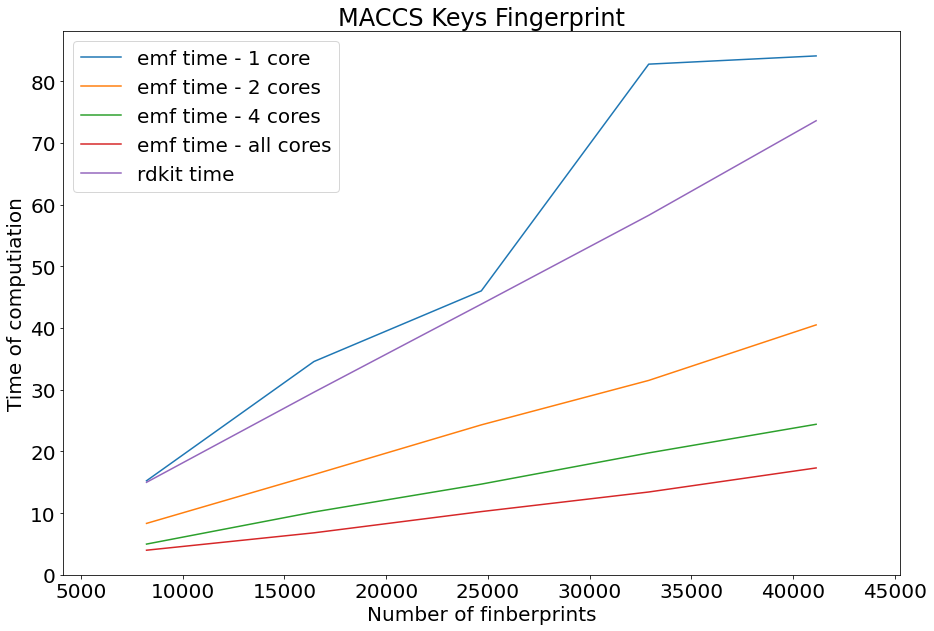

<IPython.core.display.Javascript object>

In [25]:
plot_results(MACCSKeys_emf_times, MACCSKeys_rdkit_times, "MACCS Keys Fingerprint")

## Atom Pair

In [26]:
fingerprint_types = ["default", "as_bit_vect", "hashed"]
atom_pair_emf_times = [
    [
        get_times_emf(
            X, n_molecules, AtomPairFingerprint, result_type=tp, n_jobs=n_cores
        )
        for n_cores in cores
    ]
    for tp in fingerprint_types
]

[17:50:26] WARNING: not removing hydrogen atom without neighbors
[17:50:26] WARNING: not removing hydrogen atom without neighbors
[17:50:42] WARNING: not removing hydrogen atom without neighbors
[17:50:42] WARNING: not removing hydrogen atom without neighbors
[17:50:59] WARNING: not removing hydrogen atom without neighbors
[17:50:59] WARNING: not removing hydrogen atom without neighbors
[17:51:16] WARNING: not removing hydrogen atom without neighbors
[17:51:16] WARNING: not removing hydrogen atom without neighbors
[17:51:33] WARNING: not removing hydrogen atom without neighbors
[17:51:33] WARNING: not removing hydrogen atom without neighbors
[18:03:30] WARNING: not removing hydrogen atom without neighbors
[18:03:30] WARNING: not removing hydrogen atom without neighbors
[18:04:13] WARNING: not removing hydrogen atom without neighbors
[18:04:13] WARNING: not removing hydrogen atom without neighbors
[18:04:57] WARNING: not removing hydrogen atom without neighbors
[18:04:57] WARNING: not r

<IPython.core.display.Javascript object>

In [27]:
from rdkit.Chem.rdMolDescriptors import (
    GetAtomPairFingerprint,
    GetHashedAtomPairFingerprintAsBitVect,
    GetHashedAtomPairFingerprint,
)

functions = [
    GetAtomPairFingerprint,
    GetHashedAtomPairFingerprintAsBitVect,
    GetHashedAtomPairFingerprint,
]
arom_pair_rdkit_times = [
    get_times_rdkit(X, n_molecules, function) for function in functions
]

[18:28:58] WARNING: not removing hydrogen atom without neighbors
[18:28:58] WARNING: not removing hydrogen atom without neighbors
[18:29:12] WARNING: not removing hydrogen atom without neighbors
[18:29:12] WARNING: not removing hydrogen atom without neighbors
[18:29:26] WARNING: not removing hydrogen atom without neighbors
[18:29:26] WARNING: not removing hydrogen atom without neighbors
[18:29:40] WARNING: not removing hydrogen atom without neighbors
[18:29:40] WARNING: not removing hydrogen atom without neighbors
[18:29:55] WARNING: not removing hydrogen atom without neighbors
[18:29:55] WARNING: not removing hydrogen atom without neighbors
[18:32:19] WARNING: not removing hydrogen atom without neighbors
[18:32:19] WARNING: not removing hydrogen atom without neighbors
[18:32:32] WARNING: not removing hydrogen atom without neighbors
[18:32:32] WARNING: not removing hydrogen atom without neighbors
[18:32:46] WARNING: not removing hydrogen atom without neighbors
[18:32:46] WARNING: not r

<IPython.core.display.Javascript object>

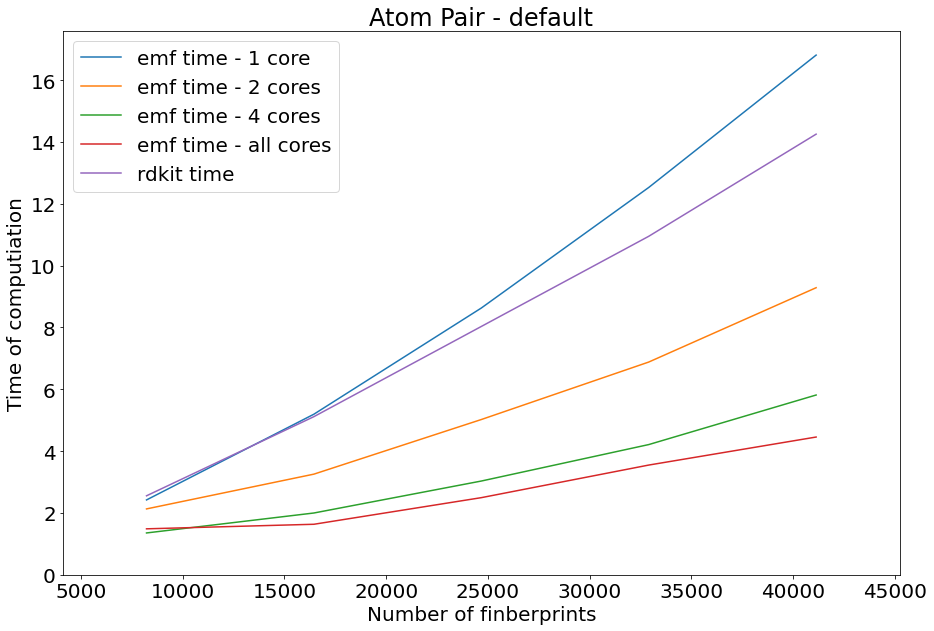

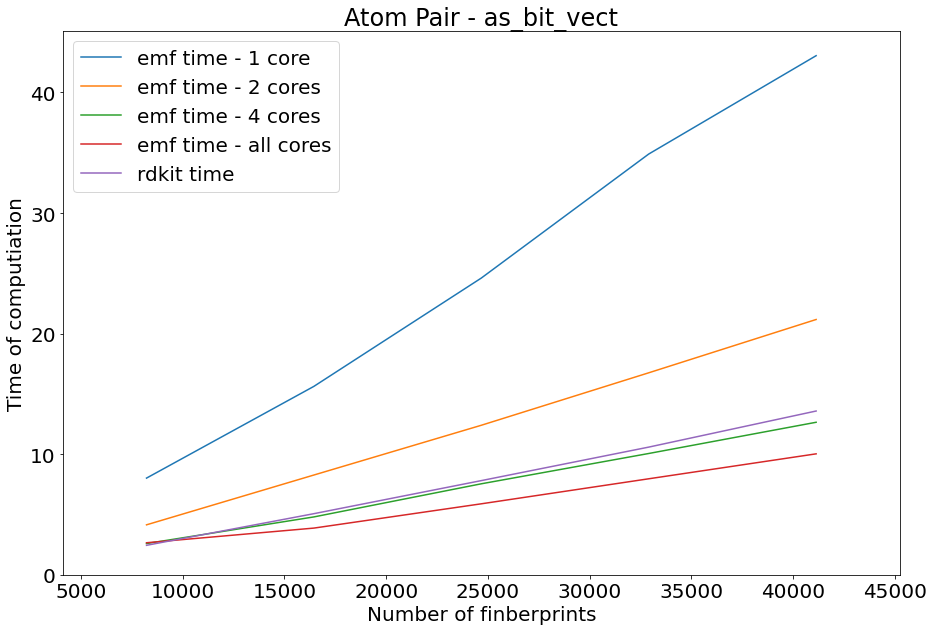

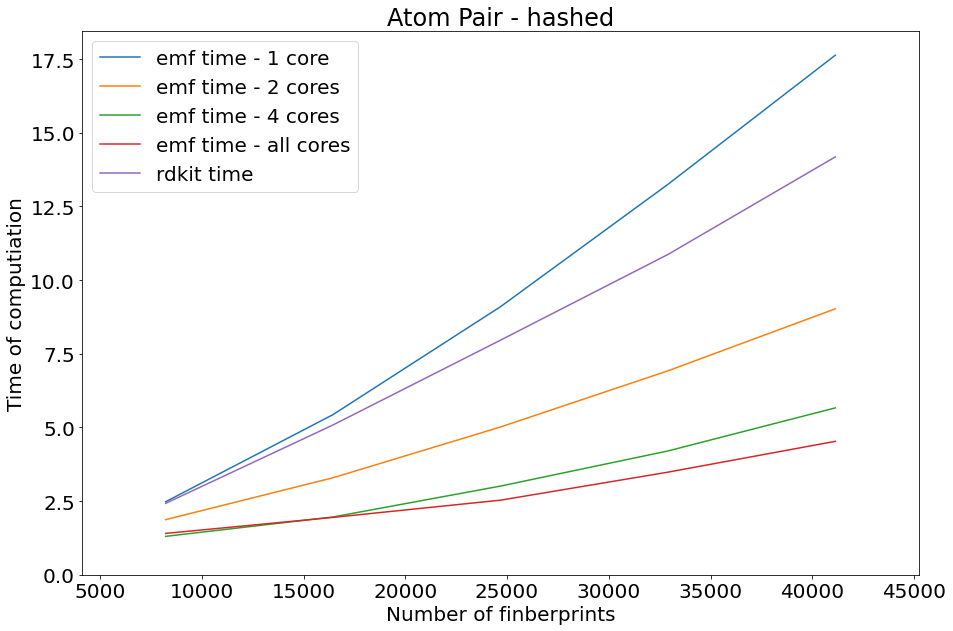

<IPython.core.display.Javascript object>

In [28]:
for i in range(3):
    plot_results(
        atom_pair_emf_times[i],
        arom_pair_rdkit_times[i],
        "Atom Pair - " + fingerprint_types[i],
    )

## Topological Torsion

In [29]:
fingerprint_types = ["default", "as_bit_vect", "hashed"]
topological_torsion_emf_times = [
    [
        get_times_emf(
            X,
            n_molecules,
            TopologicalTorsionFingerprint,
            result_type=tp,
            n_jobs=n_cores,
        )
        for n_cores in cores
    ]
    for tp in fingerprint_types
]

[18:39:30] WARNING: not removing hydrogen atom without neighbors
[18:39:30] WARNING: not removing hydrogen atom without neighbors
[18:39:47] WARNING: not removing hydrogen atom without neighbors
[18:39:47] WARNING: not removing hydrogen atom without neighbors
[18:40:04] WARNING: not removing hydrogen atom without neighbors
[18:40:04] WARNING: not removing hydrogen atom without neighbors
[18:40:21] WARNING: not removing hydrogen atom without neighbors
[18:40:21] WARNING: not removing hydrogen atom without neighbors
[18:40:38] WARNING: not removing hydrogen atom without neighbors
[18:40:38] WARNING: not removing hydrogen atom without neighbors
[18:52:45] WARNING: not removing hydrogen atom without neighbors
[18:52:45] WARNING: not removing hydrogen atom without neighbors
[18:53:28] WARNING: not removing hydrogen atom without neighbors
[18:53:28] WARNING: not removing hydrogen atom without neighbors
[18:54:12] WARNING: not removing hydrogen atom without neighbors
[18:54:12] WARNING: not r

<IPython.core.display.Javascript object>

In [30]:
from rdkit.Chem.rdMolDescriptors import (
    GetTopologicalTorsionFingerprint,
    GetHashedTopologicalTorsionFingerprintAsBitVect,
    GetHashedTopologicalTorsionFingerprint,
)

functions = [
    GetTopologicalTorsionFingerprint,
    GetHashedTopologicalTorsionFingerprintAsBitVect,
    GetHashedTopologicalTorsionFingerprint,
]
topological_torsion_rdkit_times = [
    get_times_rdkit(X, n_molecules, function) for function in functions
]

[19:19:03] WARNING: not removing hydrogen atom without neighbors
[19:19:03] WARNING: not removing hydrogen atom without neighbors
[19:19:19] WARNING: not removing hydrogen atom without neighbors
[19:19:19] WARNING: not removing hydrogen atom without neighbors
[19:19:35] WARNING: not removing hydrogen atom without neighbors
[19:19:35] WARNING: not removing hydrogen atom without neighbors
[19:19:51] WARNING: not removing hydrogen atom without neighbors
[19:19:51] WARNING: not removing hydrogen atom without neighbors
[19:20:07] WARNING: not removing hydrogen atom without neighbors
[19:20:07] WARNING: not removing hydrogen atom without neighbors
[19:22:54] WARNING: not removing hydrogen atom without neighbors
[19:22:54] WARNING: not removing hydrogen atom without neighbors
[19:23:10] WARNING: not removing hydrogen atom without neighbors
[19:23:10] WARNING: not removing hydrogen atom without neighbors
[19:23:26] WARNING: not removing hydrogen atom without neighbors
[19:23:26] WARNING: not r

<IPython.core.display.Javascript object>

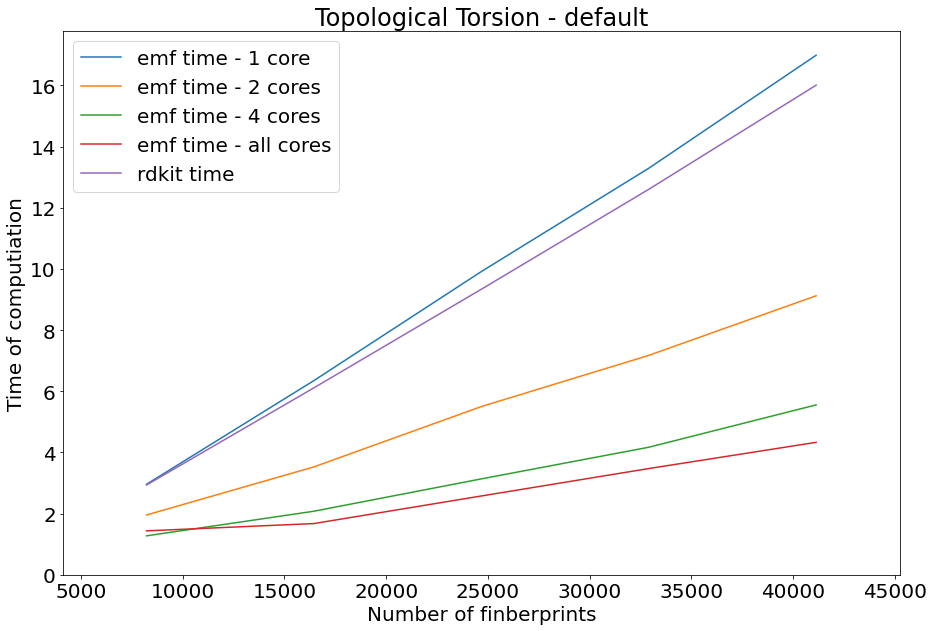

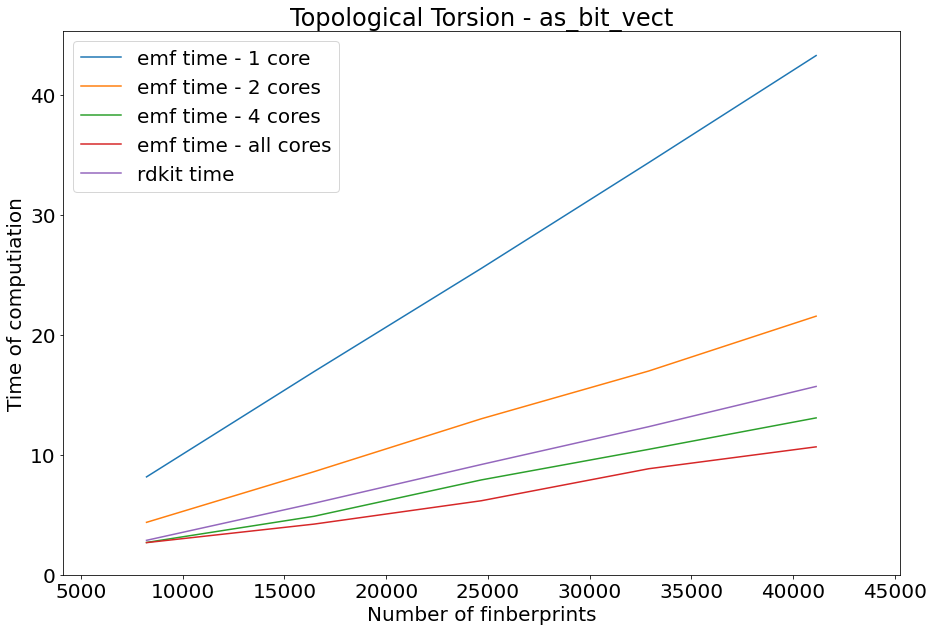

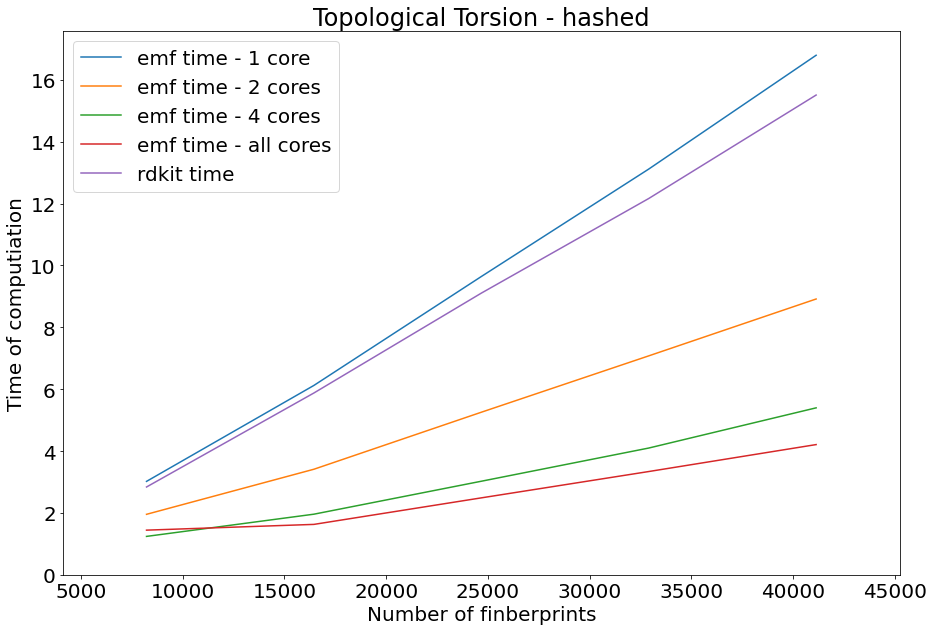

<IPython.core.display.Javascript object>

In [31]:
for i in range(3):
    plot_results(
        topological_torsion_emf_times[i],
        topological_torsion_rdkit_times[i],
        "Topological Torsion - " + fingerprint_types[i],
    )

## ERG Fingerprint

In [32]:
ERG_emf_times = [
    get_times_emf(X, n_molecules, ERGFingerprint, n_jobs=n_cores) for n_cores in cores
]

[19:31:54] WARNING: not removing hydrogen atom without neighbors
[19:31:54] WARNING: not removing hydrogen atom without neighbors
[19:32:18] WARNING: not removing hydrogen atom without neighbors
[19:32:18] WARNING: not removing hydrogen atom without neighbors
[19:32:42] WARNING: not removing hydrogen atom without neighbors
[19:32:42] WARNING: not removing hydrogen atom without neighbors
[19:33:07] WARNING: not removing hydrogen atom without neighbors
[19:33:07] WARNING: not removing hydrogen atom without neighbors
[19:33:31] WARNING: not removing hydrogen atom without neighbors
[19:33:31] WARNING: not removing hydrogen atom without neighbors


<IPython.core.display.Javascript object>

In [33]:
from rdkit.Chem.rdReducedGraphs import GetErGFingerprint

ERG_rdkit_times = get_times_rdkit(X, n_molecules, GetErGFingerprint)

[19:44:24] WARNING: not removing hydrogen atom without neighbors
[19:44:24] WARNING: not removing hydrogen atom without neighbors
[19:44:48] WARNING: not removing hydrogen atom without neighbors
[19:44:48] WARNING: not removing hydrogen atom without neighbors
[19:45:11] WARNING: not removing hydrogen atom without neighbors
[19:45:11] WARNING: not removing hydrogen atom without neighbors
[19:45:35] WARNING: not removing hydrogen atom without neighbors
[19:45:35] WARNING: not removing hydrogen atom without neighbors
[19:45:58] WARNING: not removing hydrogen atom without neighbors
[19:45:58] WARNING: not removing hydrogen atom without neighbors


<IPython.core.display.Javascript object>

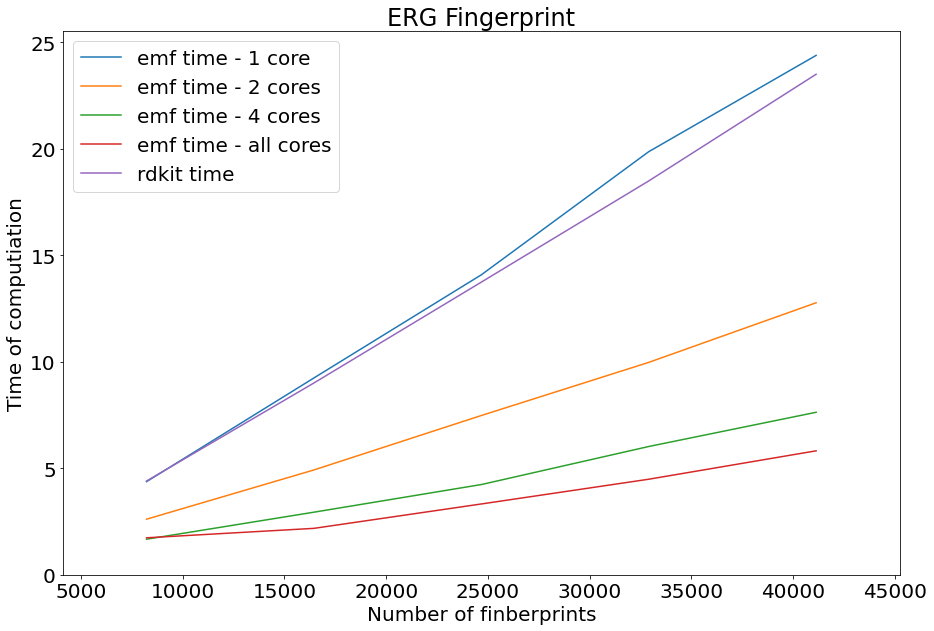

<IPython.core.display.Javascript object>

In [34]:
plot_results(ERG_emf_times, ERG_rdkit_times, "ERG Fingerprint")